In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pathlib import Path

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories ---
DERIV_03 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_03_resample")
DERIV_04 = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
os.makedirs(DERIV_04, exist_ok=True)

# Derive filename from config (synchronized with previous notebooks)
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_03) / f"{RUN_ID}__resampled.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Expected file not found: {INPUT_FILE}. Did you run notebook 03?")

df = pd.read_parquet(INPUT_FILE)

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a zero-phase low-pass Butterworth filter.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # filtfilt avoids phase shift (important for biomechanics)
    y = filtfilt(b, a, data)
    return y

# --- Parameters ---
FS = CONFIG.get('fs_target', 120.0)
CUTOFF = 10.0  # Hz - Most human movement is below 6Hz
ORDER = 4

print(f"Applying Butterworth Filter: Cutoff={CUTOFF}Hz, Order={ORDER}, FS={FS}")

Applying Butterworth Filter: Cutoff=10.0Hz, Order=4, FS=120.0


In [3]:
# Filtering Positions (px, py, pz) and Quaternions (qx, qy, qz, qw)
cols_to_filter = [c for c in df.columns if c.endswith(('__px', '__py', '__pz', '__qx', '__qy', '__qz', '__qw'))]

df_filtered = df.copy()

for col in cols_to_filter:
    df_filtered[col] = butter_lowpass_filter(df[col].values, CUTOFF, FS, ORDER)

print(f"✅ Filtered {len(cols_to_filter)} columns.")

✅ Filtered 147 columns.


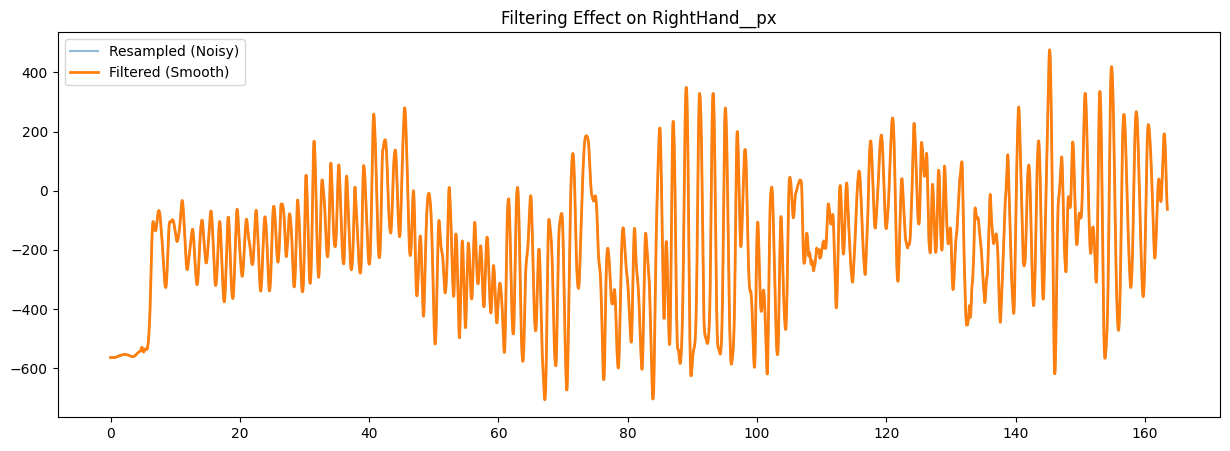

In [4]:
# Let's see how much "noise" we removed from a single joint's position
sample_col = "RightHand__px"
plt.figure(figsize=(15, 5))
plt.plot(df['time_s'], df[sample_col], label='Resampled (Noisy)', alpha=0.5)
plt.plot(df_filtered['time_s'], df_filtered[sample_col], label='Filtered (Smooth)', linewidth=2)
plt.title(f"Filtering Effect on {sample_col}")
plt.legend()
plt.show()

In [5]:
out_path = os.path.join(DERIV_04, f"{RUN_ID}__filtered.parquet")
df_filtered.to_parquet(out_path, index=False)

# Forward the map so 05 can find it
import shutil
shutil.copy(os.path.join(DERIV_03, f"{RUN_ID}__kinematics_map.json"), 
            os.path.join(DERIV_04, f"{RUN_ID}__kinematics_map.json"))

print(f"🎉 Step 04 Complete. Data saved to: {out_path}")

🎉 Step 04 Complete. Data saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__filtered.parquet


In [6]:
import json

def export_filter_summary(df_orig, run_id, save_dir, cutoff, order, fs):
    """
    Saves filtering parameters AND raw data quality metrics 
    to a JSON file for the Master Audit Report.
    """
    # חישוב מדדי איכות גולמיים עבור ה-Audit
    total_frames = len(df_orig)
    # מחשב כמה אחוז מהתאים בטורי המרקרים היו NaN לפני האינטרפולציה/סינון
    missing_pct = float(df_orig.isna().mean().mean() * 100)
    
    summary = {
        "run_id": run_id,
        "identity": {
            "timestamp": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
            "pipeline_version": "v2.5_robust"
        },
        "raw_quality": {
            "total_frames": total_frames,
            "missing_data_percent": round(missing_pct, 3),
            "sampling_rate_actual": fs
        },
        "filter_params": {
            "filter_type": "Butterworth Low-pass",
            "filter_cutoff_hz": cutoff,
            "filter_order": order,
            "applied_pre_kinematics": True
        }
    }
    
    out_path = os.path.join(save_dir, f"{run_id}__filtering_summary.json")
    with open(out_path, 'w') as f:
        json.dump(summary, f, indent=4)
    
    print(f"✅ Enhanced Filter Summary exported: {out_path}")
    print(f"📊 Quality Audit: {missing_pct:.2f}% missing data detected.")

# הרצה - שים לב שהוספנו את df כארגומנט הראשון
export_filter_summary(df, RUN_ID, DERIV_04, CUTOFF, ORDER, FS)

✅ Enhanced Filter Summary exported: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_04_filtering\734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__filtering_summary.json
📊 Quality Audit: 0.00% missing data detected.
